## Federated Learning Tutorial: Launching the Server


<img src="https://github.com/APPFL/APPFL/blob/main/docs/_static/logo/logo_small.png?raw=true" width="40%" alt="APPFL Logo">


In this tutorial, we will leverage the Advanced Privacy-Preserving Federated Learning ([APPFL](https://github.com/APPFL/APPFL)) framework to launch a federated learning server for orchestrating federated learning experiments between two distributed clients, whose client-launching code are available in your jupyter workspace as **Client1 (APPFL_Client1_IXI.ipynb)** and **Client2 (APPFL_Client2_IXI.ipynb)**.

This example will train a simple UNet using T1-weighted brain MRI images from two hospitals, HH and IOP, to do brain segmentation.

### 1. Introduction to Federated Learning

As shown in the figure below, federated learning can be understood as a distributed version of traditional machine by iterating the following two steps after a model initialization step

(1) Each client trains an ML model using its local dataset and submits the updated model to the server.

(2) The server aggregates these local models to update the global model and then sends it back to the clients for further local training.

As only model parameters are exchanged, federated learning offers a promising solution to utilize data from multiple data owners without direct data sharing, and it can usually help with training more robust, generalized, and powerful model by leveraging more training data.

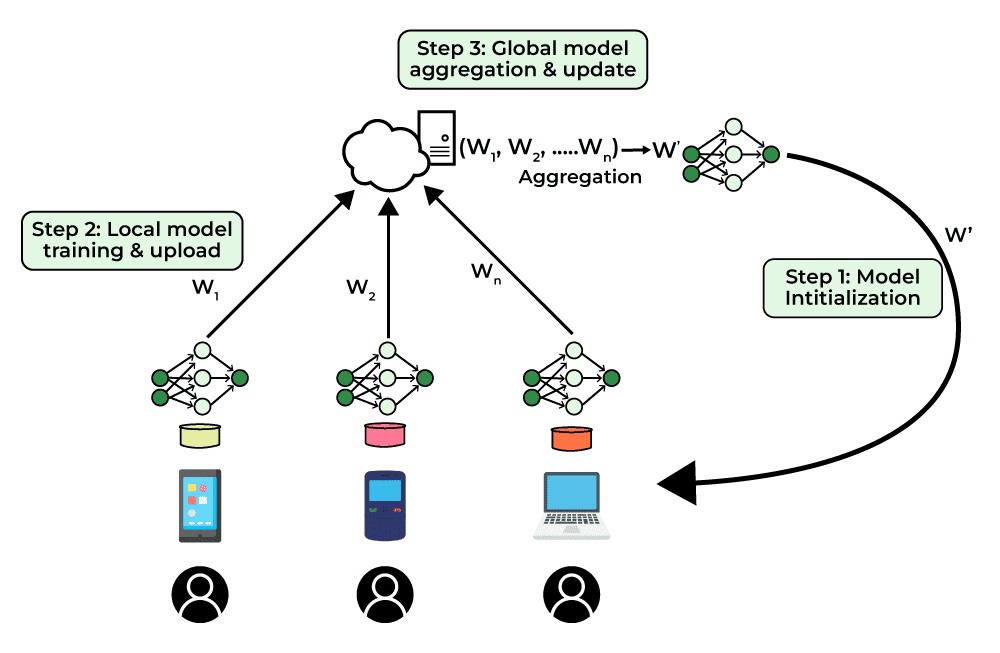

### 2. Create federated learning server agent from configurations

Here we print the configurations needed to create a federated learning server. Specifically, it is composed of two main parts: `client_configs` and `server_configs`.

The `client_configs` mainly contains **general** configurations that should be the same among all clients (e.g., training configurations, model architectures). Those configurations will be shared will all the clients at the beginning of experiments. This can avoid having each client to set the same configurations themselves separately. In this example, `client_configs` has two main components:

- `client_configs.train_configs`: This component contains configurations related to client's local training, such as the trainer to use, loss function, validation function, etc.

- `client_configs.model_configs`: This provides the path which defines the python function to load the architecture of the model to be trained.


The `server_configs` contains configurations that are specific to the federated learning server, such as the number of global epochs (total communication rounds between server and clients), and aggregators to use, etc.


 If you are interested, you can find more detailed explanations for the meanings of different configuration fields at [APPFL's official document](https://appfl.ai/en/latest/users/server_agent.html#configurations).

In [19]:
# [WARNING]: Please only run this cell ONCE at the beginning of your script.
# First: Change the working directory to the root of the repository and ignore warnings
import os
import warnings

os.chdir("../..")
warnings.filterwarnings("ignore")

In [20]:
from omegaconf import OmegaConf
from appfl.agent import ServerAgent

server_agent_config = OmegaConf.load(
    "./resources/configs/flamby/ixi/server_fedavg.yaml"
)

print("==========Server Configuration==========")
print(OmegaConf.to_yaml(server_agent_config))
print("========================================")
server_agent = ServerAgent(server_agent_config=server_agent_config)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hiniduma.1/Documents/APPFL_tutorials/resources/configs/flamby/ixi/server_fedavg.yaml'

### 3. **Data Readiness Configurations**

As shown above, there is a separate configuration block under `client_configs` called `data_readiness_configs`. This configuration allows us to enable standard **data readiness metrics** and **visualizations** that are available by default.

When enabled, the specified metrics are used to evaluate each client's data **before training begins**. These evaluations are performed locally on the client's edge device, ensuring data privacy. The evaluation results are then transmitted to the server, where they are aggregated into a **Data Readiness Report**.

---

#### Why This Matters

This feature is a valuable addition to our framework, as it helps assess the quality and readiness of the data **prior to initiating the training phase**. Key benefits include:

- **Privacy-Preserving**: Data never leaves the edge device—only the metric results are shared.
- **Resource Efficiency**: Avoids wasting compute on poor-quality data.
- **Actionable Insights**: Provides users with a clear view of their data’s readiness, enabling them to decide whether:
  - Training should proceed.
  - Data cleaning or preprocessing is required on edge devices.

By evaluating data readiness upfront, we ensure that training is both efficient and effective.

For this example let's enable the following standard data readiness metrics and visualizations:


In [ ]:
server_agent_config.client_configs.data_readiness_configs.dr_metrics.sample_size = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.data_shape = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.data_range = True
server_agent_config.client_configs.data_readiness_configs.dr_metrics.combine.feature_space_distribution = True

#### **Customizable Assurance of Data Readiness (CADRE)**

Another key feature integrated into **APPFL** is the ability for users to define **custom data readiness metrics, rules, and remedies**. This level of customization is crucial because data characteristics can vary significantly based on:

- The **modality** of the data (e.g., text, image, sensor)
- The **downstream task** (e.g., classification, regression)
- The **domain** (e.g., healthcare, finance, IoT)

To support this, APPFL introduces **Customizable Assurance of Data Readiness (CADRE)**.

---

#### What is CADRE?

CADRE allows users to plug in their own logic for assessing and improving data quality at the client level. A custom CADRE module includes three main functions:

- `metric()`: Define your own data readiness metric.
- `rule()`: Specify logic or thresholds that determine if the data passes.
- `remedy()`: Suggest or perform actions to improve the data quality if the rules are not met.

> 📄 **Documentation & Code:** [Data Readiness Assurance Framework in APPFL](https://appfl.ai/en/latest/tutorials/examples_dr_integration.html)

---

#### How It Works

Users can extend a `BaseCADREModule` and define their own `metric()`, `rule()`, and `remedy()` functions. Once defined, they can update the configuration via the `cadremodule_configs` field inside the `data_readiness_configs`.

The final **Data Readiness Report** will include results from both:
- The **standard metrics**, and
- The **custom CADRE modules**

This combined report helps users easily understand and address data readiness issues across all clients.

---

#### Example: Outlier Handling CADRE Module

We’ve already implemented a custom CADRE module designed to **detect and handle outliers** in each edge client’s dataset. Below is the implementation:

```python import torch
    import numpy as np
    from sklearn.neighbors import LocalOutlierFactor
    from appfl.misc.data_readiness import BaseCADREModule
    
    class CADREModuleLOFOutlier(BaseCADREModule):
        def __init__(self, train_dataset, contamination=0.05, n_neighbors=20, **kwargs):
            """
            Initialize the LOF-based outlier detector.
    
            Args:
            - train_dataset: The dataset to analyze.
            - contamination: Expected proportion of outliers (default: 5%).
            - n_neighbors: Number of neighbors for LOF (default: 20).
            - kwargs: Additional keyword arguments.
            """
            super().__init__(train_dataset, **kwargs)
            self.contamination = contamination
            self.n_neighbors = n_neighbors
    
        def metric(self, **kwargs):
            """
            Compute LOF outlier scores on flattened images.
    
            Returns:
            - A dictionary containing:
                - "outlier_indices": Indices of detected outliers.
                - "outlier_scores": LOF anomaly scores (lower = more anomalous).
                - "mean_outlier_score": Mean anomaly score across all samples.
            """
            # Flatten all images into vectors
            flattened_images = []
            for i in range(len(self.train_dataset)):
                img, _ = self.train_dataset[i]
                img_np = img.numpy() if hasattr(img, 'numpy') else np.array(img)
                flattened_images.append(img_np.flatten())
            X = np.vstack(flattened_images)
    
            # Detect outliers using LOF
            lof = LocalOutlierFactor(
                n_neighbors=self.n_neighbors,
                contamination=self.contamination,
                novelty=False
            )
            outlier_labels = lof.fit_predict(X)
            outlier_indices = np.where(outlier_labels == -1)[0].tolist()
            outlier_scores = -lof.negative_outlier_factor_  # Convert to positive scores
    
            return {
                "mean_outlier_score": float(np.mean(outlier_scores)),
                "outlier_indices": outlier_indices,
                "outlier_scores": outlier_scores.tolist(),
                
            }
    
        def rule(self, metric_result, **kwargs):
            """
            Return indices of detected outliers.
            """
            return metric_result["outlier_indices"]
    
        def remedy(self, metric_result, logger, **kwargs):
            """
            Remove outliers from the dataset.
            """
            all_indices = set(range(len(self.train_dataset)))
            outlier_indices = set(metric_result["outlier_indices"])
            keep_indices = list(all_indices - outlier_indices)
    
            logger.info(f"Removed {len(outlier_indices)} LOF-based outliers (contamination={self.contamination}).")
    
            cleaned_dataset = [self.train_dataset[i] for i in keep_indices]
    
            return {
                "ai_ready_dataset": cleaned_dataset,
                "metadata": {
                    "removed_indices": list(outlier_indices),
                    "removed_scores": [metric_result["outlier_scores"][i] for i in outlier_indices],
                    "mean_outlier_score": metric_result["mean_outlier_score"]
                }
            }
```

The above custom CADRE module is located at: `./resources/configs/flamby/ixi/cadre_modules/handle_outliers.py` 
Based on this file, we can update the `cadremodule_configs` section in the configuration.

- **`cadremodule_name`**: This should match the name of the class defined within the custom CADRE module.  
  In this case, the class name is: `CADREModuleLOFOutlier`
- **`remedy_action`**: A boolean flag that controls whether the remedy actions defined in the CADRE module should be executed:
  - Set to `True` to apply the remedies during the data readiness phase.
  - Set to `False` if you only want to evaluate the data without applying any modifications.

> **Note:** Even if `remedy_action` is set to `False`, standard and custom metric evaluations will still be performed and included in the **Data Readiness Report**.

This setup enables fine-grained control over how data quality issues are assessed and optionally addressed during the pre-training phase.


In [21]:
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.cadremodule_path = "./resources/configs/flamby/ixi/cadre_modules/handle_outliers.py"
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.cadremodule_name = "CADREModuleLOFOutlier"
server_agent_config.client_configs.data_readiness_configs.dr_metrics.cadremodule_configs.remedy_action = True  # Set to False to disable automatic remedies


Similarly, you can define your own custom data readiness metrics, rules, and remedies to effectively assess the quality and readiness of your data before proceeding to the training phase.

### 4. gRPC server communicator creation

In this step, we create a server communicator that facilitates communication between the server and its clients using gRPC. It provides a reliable medium for the server and clients to exchange information efficiently and asynchronously.

**The following code block will print out a link that you need to copy to your two client notebooks.**

In [22]:
import socket
from appfl.comm.grpc import GRPCServerCommunicator

# Start the gRPC server communicator
communicator = GRPCServerCommunicator(
    server_agent,
    logger=server_agent.logger,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

# Getting the private IP address of the server
hostname = socket.gethostname()
private_ip = socket.gethostbyname(hostname)
print(f"\n\n✅ Replace server_uri with below in client notebook: {private_ip}:50051")



✅ Replace server_uri with below in client notebook: 192.168.1.121:50051


### 5. Launch the Server

Finally, you can use the communicator to start serving the FL server, which will handle different requests from the two clients to finish the FL experiments.

The client training results are logged in real time as a dictionary containing metrics such as `pre_val_accuracy` and `pre_val_loss` (accuracy and loss before each client's local training round) and `val_accuracy` and `val_loss` (accuracy and loss afterward). You will observe an increase in the model accuracy as the training proceeds.

In [25]:
from appfl.comm.grpc import serve

serve(
    communicator,
    **server_agent_config.server_configs.comm_configs.grpc_configs,
)

appfl: ✅[2025-06-22 23:21:42,095 server]: Received GetConfiguration request from client Client1
appfl: ✅[2025-06-22 23:21:53,327 server]: Received InvokeCustomAction get_data_readiness_report request from client Client1


num_clients: 2


appfl: ✅[2025-06-22 23:21:55,658 server]: Received GetConfiguration request from client Client2
appfl: ✅[2025-06-22 23:22:03,651 server]: Received InvokeCustomAction get_data_readiness_report request from client Client2
appfl: ✅[2025-06-22 23:22:03,739 server]: Data readiness report saved as HTML: ./output/data_readiness_report.html


num_clients: 2


appfl: ✅[2025-06-22 23:22:25,816 server]: Received GetGlobalModel request from client Client1
appfl: ✅[2025-06-22 23:23:02,694 server]: Terminating the server ...
I0000 00:00:1750648983.760290 11144902 chttp2_transport.cc:1205] ipv6:%5B::1%5D:62572: Got goaway [11] err=UNAVAILABLE:GOAWAY received; Error code: 11; Debug Text: ping_timeout {grpc_status:14, http2_error:11, created_time:"2025-06-22T23:23:03.760271-04:00"}
